In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm 
import os 
from glob import glob 

# 데이터 로드 

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/별떠라가자_공유폴더/분석데이터/기존100hz데이터/20211203.csv',header=None)

In [ ]:
columns = ['DATE', 'ID', 'ACCEL_X', 'ACCEL_Y', 'ACCEL_Z', 'GYRO_X', 'GYRO_Y',
       'GYRO_Z', 'PITCH', 'ROLL', 'LAT', 'LON', 'VELOCITY', 'ALT', 'EVENT0',
       'EVENT1', 'EVENT2', 'EVENT3']

In [ ]:
df = df[['DATE','ACCEL_X'	,'ACCEL_Y'	,'ACCEL_Z'	,'GYRO_X'	,'GYRO_Y','GYRO_Z']]

In [ ]:
def make_timestamps(temp_df):
  temp_timestamps = np.array(temp_df['DATE'].value_counts()[temp_df['DATE'].value_counts()>=20].reset_index()['index'])
  return temp_timestamps
def make_drop_value(time_df):
  time_index = time_df.index
  time_length = len(time_index)
  drop_length = time_length - 20 
  drop_index = np.random.choice(time_index,drop_length,replace=False)
  drop_value = np.array(time_df.drop(drop_index).drop(columns = ['DATE']))
  return drop_value 

In [ ]:
timestamps = make_timestamps(df)
timestamps = timestamps[:2000]

In [ ]:
temp = [] 
for timestamp in tqdm(timestamps):
  time_df = df[df['DATE']==timestamp]
  drop_value = make_drop_value(time_df)
  temp.append(drop_value)

100%|██████████| 2000/2000 [07:12<00:00,  4.62it/s]


In [ ]:
temp = np.array(temp)

## Scaling 

In [ ]:
min = np.min(df.drop(columns='DATE'),axis=0).values
max = np.max(df.drop(columns='DATE'),axis=0).values

In [ ]:
temp = (temp-min)/(max-min)
temp = temp.astype(np.float16)

# 제너레이터 

## 제너레이터 사전 설정 

In [ ]:

def make_input(timeline):
  indexes = make_indexes(timeline)
  input = np.array(df[df['DATE']==timeline].iloc[indexes].drop(columns='DATE'))
  return input
def make_scaling(input):
  global min,max 
  from tensorflow.keras import backend as k 
  scaled_input = (input-min)/(max-min) + k.epsilon() 
  return scaled_input
def make_batch(batch_times):
  batch_input = [] 
  for batch_time in batch_times:
    temp_input = make_input(batch_time)
    temp_input = make_scaling(temp_input)
    batch_input.append(temp_input)
  return batch_input 

## 제너레이터 

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import Sequence
import math

class DataGenerator(Sequence):
  def __init__(self,timestamps,
                 batch_size: int,
               shuffle : bool = False):
        self.shuffle = shuffle        
        self.timestamps = timestamps
        self.temp = temp
        self.batch_size = batch_size
        
  def __len__(self):
    return math.ceil(len(self.timestamps) / self.batch_size)
  

  def on_epoch_end(self):
    self.indices = np.arange(len(self.timestamps))
    if self.shuffle == True:
      np.random.shuffle(self.indices)
      self.timestamps = list(np.array(self.timestamps)[self.indices])
    
  def __getitem__(self, index):
    self.batch_timestamps = self.timestamps[index*self.batch_size:(index+1)*self.batch_size]

    batch_input = self.temp[self.batch_timestamps]
    batch_input = self.temp[self.batch_timestamps]

    return batch_input, batch_input
    

In [ ]:
train_generator = DataGenerator(np.arange(200),64)
a,b = next(iter(train_generator))

In [ ]:
a.shape

(64, 20, 6)

# 오토인코더 

## 사전설정 

In [ ]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import Recall
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional, LSTM, BatchNormalization,Input,Dropout,Dense,Conv2D,Concatenate,Flatten,Conv1D,Conv2D,MaxPooling1D
from tensorflow.keras.layers import Reshape,Embedding,concatenate
from tensorflow.keras.utils import plot_model
from keras.layers.pooling import GlobalAveragePooling2D,GlobalAveragePooling3D,AveragePooling3D,MaxPooling2D

## 콜백 

In [ ]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
# loss 실시간 출력 
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback
n=0
class PlotLosses(Callback):

  def on_train_begin(self, logs={}):
    self.epochs = []
    self.losses = []
    self.val_losses = []
    self.logs = []
    self.fig = plt.figure()


  def on_epoch_end(self, epoch, logs={}):
    

    self.epochs.append(epoch)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    clear_output(wait=True)
    plt.plot(self.epochs, self.losses, label="loss")
    plt.plot(self.epochs, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])
    

#call backs 선언
plot_losses = PlotLosses()

from tensorflow.keras.callbacks import ModelCheckpoint #<- model 저장 객체, best_model.h5라는 모델 이 저장 됨 
from datetime import datetime
model_check_point = ModelCheckpoint(
    f"/content/drive/MyDrive/Colab Notebooks/Hanyang_repo/별따러가자/model/best_model.h5",
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True)


# from tensorflow.keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(
#     monitor='val_loss',  # 모니터링 대상, 이걸 기준으로 멈춤 
#     verbose=1,
#     patience=15)         # 중지까지의 여유분

# from tensorflow.keras.callbacks import ReduceLROnPlateau
# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss', # 모니터링 대상
#     patience=10,        # 대상ㅃ 기간동안 유지
#     factor=0.2,         # 줄이는 양                              
#     min_learning_rate=0.00001)     # 최소 학습율


## 모델 

In [ ]:
latent_dim = 16 
input = Input((20,6))
def make_encoder(input):
  x = Bidirectional(LSTM(64,return_sequences = True))(input)

  for i in [32,16,8,4]:
    x = Bidirectional(LSTM(i,return_sequences = True))(x)
    x= BatchNormalization()(x)
    x = Dropout(0.2)(x)
  x = Flatten()(x)
  output = Dense(latent_dim, activation = 'sigmoid')(x)
  encoder = Model(input,output,name='encoder')
  return encoder

In [ ]:
def make_decoder():
  input = Input(latent_dim)
  x = Dense(160, activation = 'sigmoid')(input)
  x = Reshape((20,8))(x)

  for i in [4,8,16,32]:
      x = Bidirectional(LSTM(i,return_sequences = True))(x)
      x = BatchNormalization()(x)
      x = Dropout(0.2)(x)
  x = Bidirectional(LSTM(64,return_sequences = True))(x)
  x = Dense(6,activation='sigmoid')(x)

  decoder = Model(input,x,name='decoder')
  return decoder

## compile 

In [ ]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

In [ ]:
initial_learning_rate = 0.0005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

optimizer = tfa.optimizers.RectifiedAdam(
    learning_rate=lr_schedule,
    total_steps=10000,
    warmup_proportion=0.1,
    min_lr=1e-5,
)

In [ ]:
from keras import backend as K
#rmse 
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

## Training 

In [ ]:
BATCH_SIZE = 128 
latent_dim = 16 
# Train - Valid 분할 
train_timestamps = np.arange(1800)
valid_timestamps = np.arange(1800,2000)
#데이터 제너레이터 
train_generator = DataGenerator(train_timestamps,BATCH_SIZE,shuffle=True)
valid_generator = DataGenerator(valid_timestamps,BATCH_SIZE)


#모델 선언 
input = Input((20,6))
encoder = make_encoder(input)
decoder = make_decoder()
autoencoder = Model(input,decoder(encoder(input)))

#컴파일 및 학습 
autoencoder.compile(optimizer=optimizer,loss = root_mean_squared_error,metrics = ['mse'])

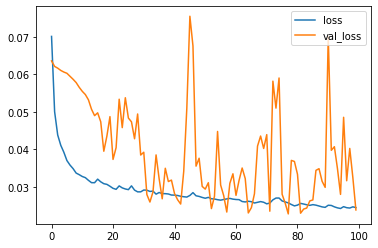

loss =  0.02449217438697815 , val_loss =  0.023866664618253708
15/15 [==============================] - 4s 233ms/step - loss: 0.0245 - mse: 0.0010 - val_loss: 0.0239 - val_mse: 9.6516e-04


In [ ]:
autoencoder.fit(train_generator,validation_data = valid_generator,epochs=100,verbose=1,callbacks=plot_losses)

#벡터머신 (인코더)

In [ ]:
train_generator = DataGenerator(train_timestamps,BATCH_SIZE,shuffle=False)
train_vector = encoder.predict(train_generator)
valid_vector =encoder.predict(valid_generator)

In [ ]:
train_vector == (1800,16) 
valid_vector == (200,16)

#가우시안 모델 

In [ ]:
from sklearn.mixture import GaussianMixture
GMM = GaussianMixture(n_components=16)
GMM.fit(vector)
GMM.mean_

GaussianMixture(n_components=16)

In [ ]:
k = GMM 

# K-means 클러스터

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(train_vector)
train_predicted = kmeans.predict(train_vector)
valid_predicted = kmeans.predict(valid_vector)

In [ ]:
timestamps

(2000,)

In [ ]:
pd.DataFrame([timestamps]).T

,0
0,2021-12-03 18:52:07
1,2021-12-03 13:24:52
2,2021-12-03 19:33:05
3,2021-12-03 19:01:27
4,2021-12-03 09:19:44
...,...
1995,2021-12-03 18:39:03
1996,2021-12-03 20:56:10
1997,2021-12-03 11:22:10
1998,2021-12-03 16:18:02


# K-means 평가 
- 실루엣  등 
- 통계검증 

# 전수 조사 